In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
# Import the pretrained AlexNet model from the torchvision library.
pretrained_alexnet = torchvision.models.alexnet(pretrained=True)
# Retrieve and list the last three layers or components of the AlexNet model.
list(pretrained_alexnet.children())[-3:] 

/Users/chenjiayu/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/chenjiayu/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Sequential(
   (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
   (1): ReLU(inplace=True)
   (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (4): ReLU(inplace=True)
   (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (7): ReLU(inplace=True)
   (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (9): ReLU(inplace=True)
   (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace=True)
   (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
 ),
 AdaptiveAvgPool2d(output_size=(6, 6)),
 Sequential(
   (0): Dropout(p=0.5, inplace=False)
   (1): Linear(in_features=9216, out_features=4096, bias=True)
   (2): ReLU(inplace=True)
   (3): Dropout(p=0.5, inplace=False)

In [3]:
# Create a new Sequential model containing all but the last layer of the pretrained AlexNet.
net = nn.Sequential(*list(pretrained_alexnet.children())[:-1]) 
# Generate a random tensor representing a single 320x480 image with 3 color channels.
X = torch.rand(size=(1,3,320,480))
# Pass the random image through the network and print the output shape.
net(X).shape  

torch.Size([1, 256, 6, 6])

In [4]:
num_classes = 21

# Modify the upsampling layers to match the input and output channels correctly
net.add_module('upsample1', nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1))
net.add_module('upsample2', nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1))

# Add adaptive upsampling layer to match the target dimensions
net.add_module('adaptive_upsample', nn.AdaptiveAvgPool2d((320, 480)))

# Final convolution layer to adjust the number of output channels
net.add_module('final_conv', nn.Conv2d(256, num_classes, kernel_size=1))

In [5]:
# This function defines a bilinear kernel for use in upsampling layers, 
# creating a weight matrix based on the specified input/output channels and kernel size.
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = torch.arange(kernel_size).reshape(-1, 1), torch.arange(kernel_size).reshape(1, -1)
    filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))
    for i in range(in_channels):
        weight[i, min(i, out_channels-1), :, :] = filt
    return weight

Input image shape: torch.Size([717, 1280, 3])


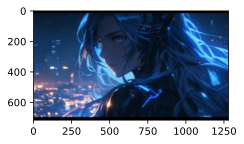

Output image shape: torch.Size([1434, 2560, 3])


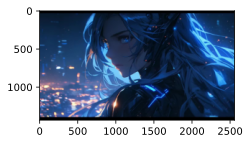

In [6]:
# Initialize a ConvTranspose2d layer
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2, bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4))  # Initialize with bilinear kernel

# Load and process an image
img_path = '1.jpg'  # Replace with your image path
img = torchvision.transforms.ToTensor()(d2l.Image.open(img_path))
X = img.unsqueeze(0)

# Apply the transposed convolution (upsampling)
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

# Visualization
d2l.set_figsize()
print('Input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0).numpy())
d2l.plt.show()

print('Output image shape:', out_img.shape)
d2l.plt.imshow(out_img.numpy())
d2l.plt.show()

In [7]:
# Initialize a bilinear kernel and copy it to the upsample layers' weights in the network.
W = bilinear_kernel(256, 256, 4) # Create a 256x256 bilinear kernel with a scale factor of 4.
net.upsample1.weight.data.copy_(W) # Copy the kernel to the first upsample layer's weights.
net.upsample2.weight.data.copy_(W) # Copy the kernel to the second upsample layer's weights.

tensor([[[[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         ...,

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
       

In [8]:
batch_size, crop_size = 32, (320,480) # Define the batch size as 32 and crop size as 320x480 pixels.
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size) # Load VOC dataset with specified batch and crop sizes.

read 1114 examples
read 1078 examples


loss 0.685, train acc 0.800, test acc 0.782
1.3 examples/sec on [device(type='cpu')]


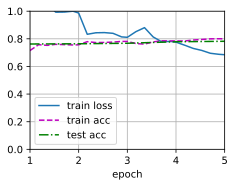

In [12]:

def loss(inputs, targets):
    # Define a custom loss function that calculates the mean cross-entropy loss per pixel.
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)    

# Set hyperparameters and initialize the trainer for the network.
num_epochs, lr, wd = 5, 0.001, 1e-3
devices = [torch.device('cpu')] # My computer only supports cpu training
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
net.to(devices[0]) # Keep the training process on cpu.
# Train the network with the specified training and test data, loss function, trainer, number of epochs, and devices.
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)   

In [13]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1) 
    return pred.reshape(pred.shape[1],pred.shape[2]) 

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

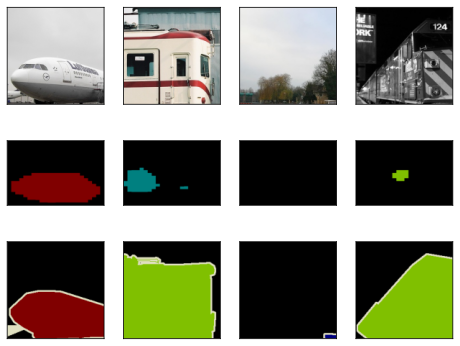

In [14]:
# Convert prediction labels to corresponding color images.
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0]) # Load the VOC colormap to the specified device.
    X = pred.long() # Ensure predictions are in long format for indexing.
    return colormap[X,:] # Map each label to its corresponding color.

# Prepare VOC2012 dataset.
voc_dir = d2l.download_extract('voc2012','VOCdevkit/VOC2012') # Download and extract the VOC2012 dataset.
test_images, test_labels = d2l.read_voc_images(voc_dir, False) # Read the images and labels from the dataset.

n, imgs = 4, [] # Set the number of images to display and initialize an empty list for images.
for i in range(n):
    crop_rect = (0,0,224,224) # Define the cropping rectangle.
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect) # Crop the test image.
    pred = label2image(predict(X)) # Predict the labels for the cropped image and convert to color image.
    # Store the cropped test image, predicted color image, and cropped test label image.
    imgs += [X.permute(1,2,0), pred.cpu(), torchvision.transforms.functional.crop(test_labels[i],*crop_rect).permute(1,2,0)]

# Display the images in a 3xN grid where N is the number of images, showing the test images, predictions, and labels.
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3],3,n,scale=2) 